<img src="https://raw.githubusercontent.com/MLMI2-CSSI/foundry/main/assets/foundry-black.png" width=450>

# Foundry Bandgap Data Quickstart for Beginners

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MLMI2-CSSI/foundry/blob/main/examples/bandgap/bandgap_demo.ipynb)

This introduction uses Foundry to:


1.   Instantiate and authenticate a Foundry client locally or in the cloud
2.   Aggregate data from the collected datasets
3. Build a simple predictive model

This notebook is set up to run as a [Google Colaboratory](https://colab.research.google.com/notebooks/intro.ipynb#scrollTo=5fCEDCU_qrC0) notebook, which allows you to run python code in the browser, or as a [Jupyter](https://jupyter.org/) notebook, which runs locally on your machine.

The code in the next cell will detect your environment to make sure that only cells that match your environment will run.


In [ ]:
try:
    import google.colab
    no_local_server = True
    no_browser = True
    globus = False
except: # when not in google colab
    no_local_server = False
    no_browser = False
    globus = True

# Environment Set Up
First we'll need to install Foundry as well as a few other packages. If you're using Google Colab, this code block will install these packages into the Colab environment.
If you are running locally, it will install these modules onto your machine if you do not already have them. We also have a [requirements file](https://github.com/MLMI2-CSSI/foundry/tree/main/examples/bandgap) included with this notebook. You can run `pip install -r requirements.txt` in your terminal to set up your environment locally.

In [ ]:
!pip install pymatgen
!pip install matminer
!pip install matplotlib
!pip install scikit-learn
!pip install foundry_ml

#we need this version of numpy
!pip install numpy==1.25.0

We need to import a few packages. We'll be using [Matplotlib](https://matplotlib.org/) to make visualizations of our data, [scikit-learn](https://scikit-learn.org/stable/) to create our model, and [pandas](https://pandas.pydata.org/) and [NumPy ](https://numpy.org/)to work with our data.

In [ ]:
%matplotlib inline

from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import warnings
import glob
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, ShuffleSplit, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics


warnings.filterwarnings('ignore')

# Instantiate and Authenticate Foundry
Once the installations are complete, we can import Foundry.

In [ ]:
from foundry import Foundry

We'll also need to instantiate it. To do so, you'll need a [Globus](https://www.globus.org) account. Once you have your account, you can instantiate Foundry using the code below. When you instantiate Foundry locally, be sure to have your Globus endpoint turned on (you can do that with [Globus Connect Personal](https://www.globus.org/globus-connect-personal)). When you instantiate Foundry on Google Colab, you'll be given a link in the cell's output and asked to enter the provided auth code.

In [ ]:
f = Foundry(no_local_server=no_local_server, no_browser=no_browser, index="mdf")

# Loading the Band Gap Data
Now that we've installed and imported everything we'll need, it's time to load the data. We'll be loading 2 datasets from Foundry using `f.load` to load the data and then `f.load_data` to load the data into the client. Then we'll concatenate them using pandas.

In [ ]:
f.load("foundry_mp_band_gaps_v1.1", globus=globus)
res = f.load_data()
X_mp,y_mp = res['train'][0], res['train'][1]

In [ ]:
f.load("foundry_assorted_computational_band_gaps_v1.1", globus=globus)
res = f.load_data()
X_assorted,y_assorted = res['train'][0], res['train'][1]

In [ ]:
X, y = pd.concat([X_mp, X_assorted]), pd.concat([y_mp, y_assorted])

Let's see the data!

In [ ]:
X.head()

,reference,icsd_id,structure,composition,comments,bandgap type,comp method,space group
0,Materials Project,[42745],"{'@module': 'pymatgen.core.structure', '@class...",KOsN(Cl2O)2,MP metalic material,I,PBE,Cmc2_1
1,Materials Project,[],"{'@module': 'pymatgen.core.structure', '@class...",Mn9CdO10,MP metalic material,I,PBE,C2/m
2,Materials Project,"[15023, 14168]","{'@module': 'pymatgen.core.structure', '@class...",CuTeO3,MP metalic material,I,PBE,Pnma
3,Materials Project,[],"{'@module': 'pymatgen.core.structure', '@class...",Li8MnFe7(BO3)8,MP metalic material,I,PBE,P1
4,Materials Project,[245254],"{'@module': 'pymatgen.core.structure', '@class...",Ba3SrIr2O9,MP metalic material,I,PBE,C2/c


# Add Composition Features
We need to pull out the composition data that will serve as our targets.

In [ ]:
n_datapoints = 300
data = StrToComposition(target_col_id='composition_obj')
data = data.featurize_dataframe(X[0:n_datapoints],
                                 'composition',
                                 ignore_errors=True)
y_subset = y[0:n_datapoints]['bandgap value (eV)']

StrToComposition:   0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
y_subset

0      0.0010
1      0.0010
2      0.0010
3      0.0010
4      0.0010
        ...  
295    0.0128
296    0.0128
297    0.0128
298    0.0130
299    0.0130
Name: bandgap value (eV), Length: 300, dtype: float64

In [ ]:
assert(len(y_subset) == len(data))

# Add Other Features
Choose the features that we'll use in training.

In [ ]:
feature_calculators = MultipleFeaturizer([cf.Stoichiometry(),
                                          cf.ElementProperty.from_preset("magpie"),
                                          cf.ValenceOrbital(props=['avg']),
                                          cf.IonProperty(fast=True)])
feature_labels = feature_calculators.feature_labels()

data = feature_calculators.featurize_dataframe(data,
                                               col_id='composition_obj',
                                               ignore_errors=False);

MultipleFeaturizer:   0%|          | 0/300 [00:00<?, ?it/s]

# Grid Search and Fit Model
Set up the grid search model using a random forest regressor as our estimator. Then, fit the model!

In [ ]:
quick_demo=False
est = RandomForestRegressor(n_estimators=30 if quick_demo else 150, n_jobs=-1)

model = GridSearchCV(est,
                     param_grid=dict(max_features=range(8,15)),
                     scoring='neg_mean_squared_error',
                     cv=ShuffleSplit(n_splits=1,
                                     test_size=0.1))
model.fit(data[feature_labels], y_subset)


GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=None, test_size=0.1, train_size=None),
             estimator=RandomForestRegressor(n_estimators=150, n_jobs=-1),
             param_grid={'max_features': range(8, 15)},
             scoring='neg_mean_squared_error')

# Cross Validation and Scoring
Perform cross validation to ensure our error values are below the desired thresholds.

In [ ]:
cv_prediction = cross_val_predict(model,
                                  data[feature_labels],
                                   y_subset,
                                  cv=KFold(10, shuffle=True))

In [ ]:
for scorer in ['r2_score', 'mean_absolute_error', 'mean_squared_error']:
    score = getattr(metrics,scorer)( y_subset, cv_prediction)
    print(scorer, score)

r2_score -0.09491878596683567
mean_absolute_error 0.003113526613756614
mean_squared_error 1.2940635271908054e-05


# Make Plots
Plot the data for our bandgap analysis.

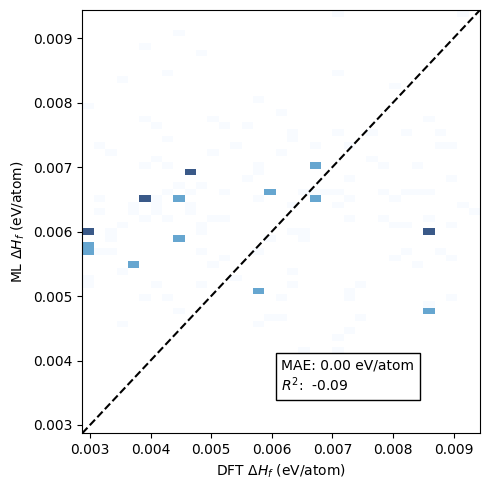

In [ ]:
fig, ax = plt.subplots()

ax.hist2d(pd.to_numeric( y_subset),
          cv_prediction,
          norm=LogNorm(),
          bins=64,
          cmap='Blues',
          alpha=0.8)

ax.set_xlim(ax.get_ylim())
ax.set_ylim(ax.get_xlim())

mae = metrics.mean_absolute_error( y_subset,
                                  cv_prediction)
r2 = metrics.r2_score( y_subset,
                      cv_prediction)
ax.text(0.5, 0.1, 'MAE: {:.2f} eV/atom\n$R^2$:  {:.2f}'.format(mae, r2),
        transform=ax.transAxes,
        bbox={'facecolor': 'w', 'edgecolor': 'k'})

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.set_xlabel('DFT $\Delta H_f$ (eV/atom)')
ax.set_ylabel('ML $\Delta H_f$ (eV/atom)')

fig.set_size_inches(5, 5)
fig.tight_layout()
fig.savefig('oqmd_cv.png', dpi=320)